In [13]:
#Setup
import os, subprocess

print os.getcwd()
newdir = os.path.expanduser('~/scikitquic')
print newdir
os.chdir(newdir)

/projects/b2387e25-7d6d-4e0d-b9f1-0c7ab8018b11/scikitquic
/projects/b2387e25-7d6d-4e0d-b9f1-0c7ab8018b11/scikitquic


In [1]:
# %load examples/plot_functional_brain_networks.py
"""
Estimate Functional Connectivity using an estimator for Sparse Inverse Covariances
==================================================================================
This example constructs a functional connectome using the sparse penalized MLE estimator implemented using QUIC.

This function extracts time-series from the ABIDE dataset, with nodes defined using regions of interest from the 
Power-264 atlas (Power, 2011).
Power, Jonathan D., et al. "Functional network organization of the
human brain." Neuron 72.4 (2011): 665-678.

Then we estimate separate inverse covariance matrices for one subject

"""

##############################################################################

import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets, connectome, plotting, input_data

# Retrieve the atlas and the data
from nilearn import datasets

# Fetch the coordinates of power atlas
power = datasets.fetch_coords_power_2011()
coords = np.vstack((
    power.rois['x'],
    power.rois['y'],
    power.rois['z'],
)).T

# No ROI labels available

# Loading the functional datasets
abide = datasets.fetch_abide_pcp(n_subjects=1)
abide.func = abide.func_preproc

# print basic information on the dataset
print('First subject functional nifti images (4D) are at: %s' %
      abide.func[0])  # 4D data
      
###############################################################################
# Masking: taking the signal in a sphere of radius 5mm around Power coords

masker = input_data.NiftiSpheresMasker(seeds=coords,
                                       smoothing_fwhm=4,
                                       radius=5.,
                                       standardize=True,
                                       detrend=True,
                                       low_pass=0.1,
                                       high_pass=0.01,
                                       t_r=2.5)

timeseries = masker.fit_transform(abide.func[0])


First subject functional nifti images (4D) are at: /projects/b2387e25-7d6d-4e0d-b9f1-0c7ab8018b11/nilearn_data/ABIDE_pcp/cpac/nofilt_noglobal/Pitt_0050003_func_preproc.nii.gz


/projects/sage/sage-6.10/local/lib/python2.7/site-packages/matplotlib-1.5.0-py2.7-linux-x86_64.egg/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [18]:
from inverse_covariance import InverseCovariance,pyquic

In [23]:
###############################################################################
# Extract and plot covariance and sparse covariance

# Compute the sparse inverse covariance
from inverse_covariance import InverseCovariance,pyquic

Shat =  np.cov(timeseries[:,:],rowvar=0)
estimator = InverseCovariance(lam = float(.5*np.max(np.triu(np.abs(Shat),1))), mode='default',verbose=1)
estimator.fit(Shat)

InverseCovariance(Sigma0=None, Theta0=None, initialize_method='corrcoef',
         lam=0.452741278908, max_iter=1000, method='quic',
         metric='log_likelihood', mode='default', path=None, tol=1e-06,
         verbose=1)

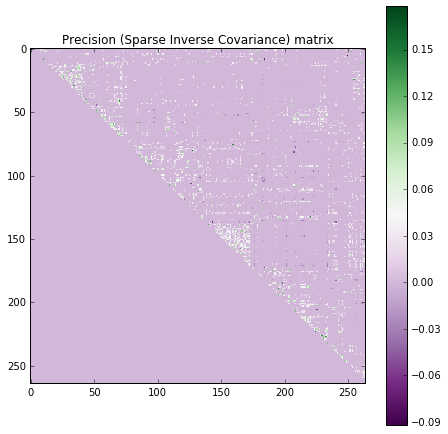

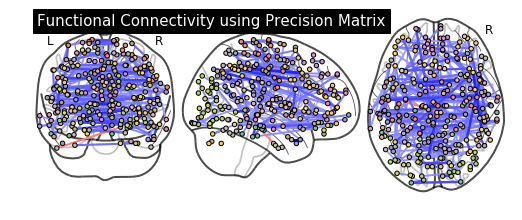

In [24]:
# Display the sparse inverse covariance
plt.figure(figsize=(7.5, 7.5))
plt.imshow(np.triu(-estimator.precision_,1), interpolation="nearest", cmap=plt.cm.PRGn)

# plt.imshow(estimator.precision_, interpolation="nearest",
#           vmax=1, vmin=-1, cmap=plt.cm.PRGn)

# Display the labels, if available. Not available for Power's Coordinates
# x_ticks = plt.xticks(range(len(labels)), labels, rotation=90)
# y_ticks = plt.yticks(range(len(labels)), labels)
plt.title('Precision (Sparse Inverse Covariance) matrix')
plt.colorbar()

# And now display the corresponding graph
plotting.plot_connectome(estimator.precision_, coords,
                         title='Functional Connectivity using Precision Matrix',
                         edge_threshold="99.2%",
                         node_size=20)
plotting.show()